In [1]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr')
sys.path.append('../..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso

In [2]:
from utils import calc_avg_cov

In [3]:
import pickle

In [4]:
with open('../../../data/selection_badreps.dat', 'rb') as f:
    uoil = pickle.load(f)
    lasso = pickle.load(f)
    en = pickle.load(f)
    scad = pickle.load(f)
    mcp = pickle.load(f)

In [5]:
# Fix the SNR, betawidth, pick a few sparsities. Plot the average selection accuracy vs. the condition number
# versus the average covariance

In [6]:
from postprocess_utils import apply_df_filters, average_fields, unique_cov_params

In [7]:
uoil_ = apply_df_filters(uoil, kappa = 5, betadict={'betawidth' : np.inf})
lasso_ = apply_df_filters(lasso, kappa = 5, betadict={'betawidth' : np.inf})
en_ = apply_df_filters(en, kappa = 5, betadict={'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa = 5, betadict={'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa = 5, betadict={'betawidth' : np.inf})

In [8]:
sparsities = np.unique(uoil_['sparsity'].values)

In [9]:
sparsities

array([0.04624822, 0.06115754, 0.08087327, 0.10694488, 0.14142136,
       0.18701223, 0.2473005 , 0.32702428, 0.4324491 , 0.57186037,
       0.7562145 , 1.        ])

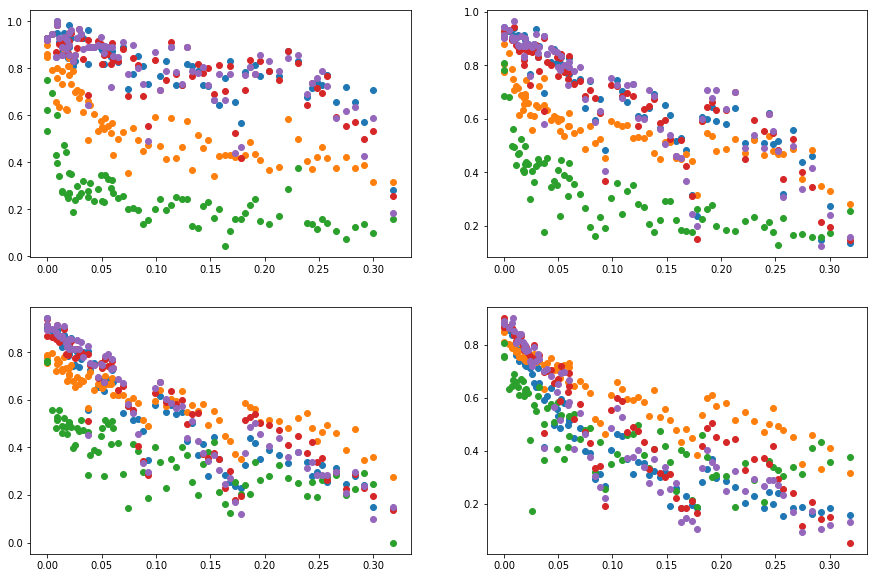

In [27]:
sparsity_ = [sparsities[1], sparsities[4], sparsities[6], sparsities[8]]

fig, ax = plt.subplots(2, 2, figsize = (15, 10))

dframes = [uoil_, lasso_, en_, scad_, mcp_]

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Need to acquire the unique cov params, and then average fields over those indices    
    for df in dframes:
        df = apply_df_filters(df, sparsity=s)
        cov_params, rep_idxs = unique_cov_params(df)
        sa = average_fields(df, ['sa'], rep_idxs)[0]
        avgcov = [calc_avg_cov(500, **cp) for cp in cov_params]        
        a.plot(avgcov, sa, 'o')


In [59]:
def condition_number(cov_params, n_features=500):
    # For each covariance matrix, sample 100 design matrices and calculate the average condition number 
    # that results
    n_reps = 25
    n_samples = 4 * n_features
    
    sigma = []
    
    for params in cov_params:
        sigma.append(gen_covariance(n_features,
                                params['correlation'], 
                                params['block_size'],
                                params['L'],
                                params['t']))
    condition_numbers = np.zeros(len(sigma))
    cnum_var = np.zeros(len(sigma))
    
    for j, s in enumerate(sigma):
        cnums = np.zeros(n_reps)
        for i in range(n_reps):
            X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
            cnums[i] = np.linalg.cond(X)

        condition_numbers[j] = np.mean(cnums)
        cnum_var[j] = np.std(cnums)    
        print(j)
        
    return condition_numbers, cnum_var

In [60]:
condition_numbers, cnum_var = condition_number(ucp1, n_features = 500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [72]:
# Task: Order values so that the ordering, indexed by dict_list, matches the ref_dict
def match_by_dict(values, dict_list, ref_dict_list): 
    dict_list = deepcopy(dict_list)
    ref_dict_list = deepcopy(ref_dict_list)
    
    values = np.array(values)
    permutation = np.zeros(values.size)
    matched_idxs = []
    unfound_idxs = []
    for i, val in enumerate(values):
        idx_dict = dict_list[i]
        found = False
        for j in range(len(ref_dict_list)):
            if j in matched_idxs: 
                continue
            if idx_dict == ref_dict_list[j]:
                matched_idxs.append(j)
                found = True
                break
        # If the value is not found, return a 
        if not found:
            values[i] = np.nan
            permutation[i] = np.nan
        
        else:
            permutation[i] = j
                        
    values = values[np.invert(np.isnan(values))]
    permutation = permutation[np.invert(np.isnan(permutation))].astype(int)
        
    return values[np.array(permutation)]

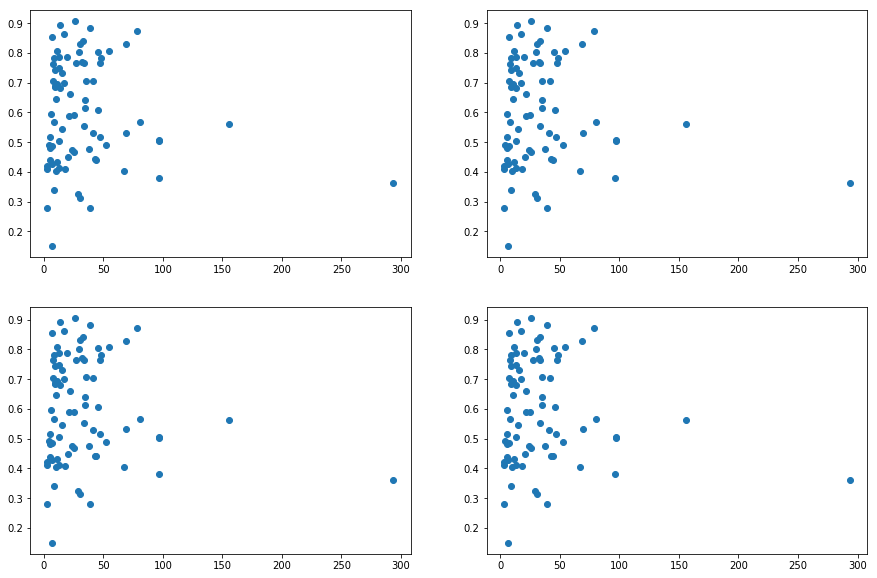

In [75]:
sparsity_ = [sparsities[1], sparsities[4], sparsities[6], sparsities[8]]

fig, ax = plt.subplots(2, 2, figsize = (15, 10))

dframes = [uoil_]

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Need to acquire the unique cov params, and then average fields over those indices    
    for df in dframes:
        
        cov_params, rep_idxs = unique_cov_params(df)
        sa = average_fields(df, ['sa'], rep_idxs)[0]
        cnums = match_by_dict(condition_numbers, ucp1, cov_params)
        
        a.plot(cnums, sa, 'o')


In [ ]:
# Not good...

In [52]:
uoil2 = apply_df_filters(uoil_, sparsity = sparsity_[3])
lasso2 = apply_df_filters(lasso_, sparsity = sparsity_[1])